# XGBoostによる分類モデルのテスト
最適なパラメータを探す
## データ準備

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics._scorer import _SCORERS
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [1]:
df = pd.read_csv("./fake_job_postings.csv")
df = df.drop("job_id", axis=1) # job_id = 0,1,2,... 学習価値なし
df.fillna('null', inplace=True) # 空の文字列 -> null

# 偽文書と本物文書
Fakedf = df[ df['fraudulent'] == 1 ]
Realdf = df[ df['fraudulent'] == 0 ]

# 問題文データのランダム抽出 (偽文書割合50%)
detaset_Fake, quiz_Fake = train_test_split(Fakedf, test_size=50)
detaset_Real, quiz_Real = train_test_split(Realdf, test_size=50)

# 問題文データのランダムシャッフル
quizdf = pd.concat([quiz_Real, quiz_Fake])
shuffled_df = quizdf.sample(frac=1).reset_index(drop=True)
quiz = shuffled_df.drop("fraudulent", axis=1)        # 問題文
quiz_solution = shuffled_df["fraudulent"].to_numpy() # 解答

# 訓練データとテストデータへの分割 (テストデータ25%)
train_Fake, test_Fake = train_test_split(detaset_Fake)
train_Real, test_Real = train_test_split(detaset_Real)
traindf = pd.concat([train_Real, train_Fake])
testdf = pd.concat([test_Real, test_Fake])
traindf = traindf.sample(frac=1).reset_index(drop=True)
testdf = testdf.sample(frac=1).reset_index(drop=True)
train_X = testdf.drop('fraudulent', axis=1)
train_y = testdf['fraudulent']
test_X = testdf.drop('fraudulent', axis=1)
test_y = testdf['fraudulent']

データの傾向を確認する。

In [20]:
print(train_X.head())

                                   title                location  \
0                               Attorney  US, VA, Virginia Beach   
1     Senior QA Engineer (3-4 Years Exp)       IN, DL, New Delhi   
2  Project Administrator Project Support      PH, , QUEZON CITY    
3            Creative Digital Copywriter           GR, I, Athens   
4                         Marketing Lead       US, CA, San Diego   

       department   salary_range  \
0            null           null   
1            null  300000-600000   
2  Administrator     10000-30000   
3        Creative           null   
4            null           null   

                                     company_profile  \
0  Tidewater Finance Co. was established in 1992 ...   
1  Practical Fish was founded in June, 2012 with ...   
2  Collabera is a fast growing, end-to-end inform...   
3  Tribal Worldwide Athens is a digitally centric...   
4  Cashie Commerce is the fastest way to create a...   

                                     

カテゴリカルデータの値と頻度を確認

In [29]:
category_columns = ['location','department','employment_type','required_experience','required_education','industry','function']
for cc in category_columns:
    print(f"---{cc}---")
    pprint(df[cc].value_counts())

---location---
location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
null                     346
                        ... 
GB, SFK, Leiston           1
GB, LND, Hammersmith       1
US, WA, Seattle            1
BE                         1
GB, WSX, Chichester        1
Name: count, Length: 3106, dtype: int64
---department---
department
null                                           11547
Sales                                            551
Engineering                                      487
Marketing                                        401
Operations                                       270
                                               ...  
Commercial Management / Contract Management        1
Exec                                               1
Marcomm                                            1
CRM                                                1
Hospitality                                        1
Name: 

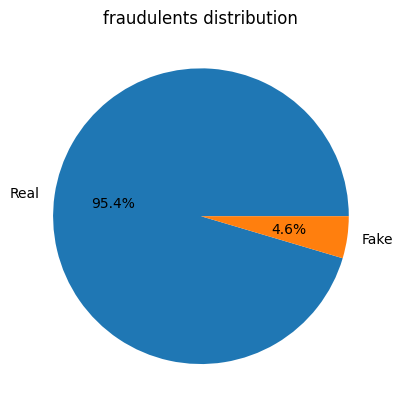

In [15]:
train_y.value_counts().rename(index={0: 'Real', 1: 'Fake'}).plot(kind='pie', autopct='%1.1f%%')
plt.title('fraudulents distribution')
plt.ylabel('')  # y軸ラベルを非表示にする
plt.show()

偽文書と本物文書の割合が不均衡のため、精度だけでモデル性能を評価するのは適切ではない。
不均衡なデータセットでは、多数派クラス（この場合はReal）を予測するだけで高い精度を達成できるため、モデルの真の性能を正確に反映しないことがある。

よって評価にはF1 score（適合率と再現率の調和平均）を用いる。
- 適合率（Precision）
  - 適合率はFakeと予測されたインスタンスのうち、実際にFakeである割合。
  - 積極的にRealと予測するとPrecisionが高くなる
- 再現率（Recall）
  - 再現率は、実際にFakeであるインスタンスのうち、正しくFakeと予測された割合です。
  - 積極的にFakeと予測するとRecallが高くなる
- 両者はトレードオフ関係にあり、バランスが大事

In [18]:
# 利用可能な評価指標
pprint(sorted(_SCORERS.keys()))

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

### 訓練データの加工
前処理を行って、データを扱いやすくする。

#### カテゴリカルデータのエンコード

In [32]:
encoded_train_X = pd.get_dummies(train_X, columns=['employment_type'])
encoded_test_X = pd.get_dummies(test_X, columns=['employment_type'])
print(encoded_train_X.columns)

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'required_experience',
       'required_education', 'industry', 'function',
       'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary', 'employment_type_null'],
      dtype='object')


required_experienceとrequired_educationをレベル別に数値化する。

In [ ]:
# required_experience
def encoder_experience(text):
    education_levels = {
        "Unspecified": 0,
        "null": 0,
        "Some High School Coursework": 1,
        "High School or equivalent": 2,
        "Vocational - HS Diploma": 2,
        "Some College Coursework Completed": 3,
        "Associate Degree": 4,
        "Vocational - Degree": 5,
        "Certification": 5,
        "Bachelor's Degree": 5,
        "Professional": 6,
        "Master's Degree": 7,
        "Doctorate": 8
    }
    return education_levels.get(text, None)

## モデル構築1 (データ加工なし)

In [21]:
model = XGBClassifier(random_state=0) # fix seed

parameters = {
    "n_estimators" : [10, 20, 50, 100, 200, 500],
    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
}
model_opt = GridSearchCV(model, parameters, scoring="f1")
model_opt.fit(train_X, train_y)
print(model_opt.best_params_)

ValueError: 
All the 300 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\sklearn.py", line 1496, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\core.py", line 1528, in __init__
    self._init(
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\core.py", line 1587, in _init
    it.reraise()
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\core.py", line 575, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\core.py", line 556, in _handle_exception
    return fn()
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\core.py", line 640, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\data.py", line 1280, in next
    input_data(**self.kwargs)
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\core.py", line 623, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\data.py", line 1315, in _proxy_transform
    arr, feature_names, feature_types = _transform_pandas_df(
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\data.py", line 490, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\xgboost\data.py", line 308, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:title: object, location: object, department: object, salary_range: object, company_profile: object, description: object, requirements: object, benefits: object, employment_type: object, required_experience: object, required_education: object, industry: object, function: object
